In [ ]:
# Parse xmls
# preprocess documents
# create bins
# output - processed document bins

# EOS To MongDB

In [1]:
import pymongo
from pymongo import MongoClient
import glob
import datetime
import pprint
import codecs
import xmltodict
import gensim
import string 
from bson.objectid import ObjectId
from multiprocessing import Pool
import gzip

import pickle
from matplotlib import pyplot as plt
%matplotlib notebook
import dateparser
from datetime import datetime

import spacy
nlp = spacy.load('en')

In [3]:

def get_db(): 
    client = MongoClient('localhost:27017') 
    db = client.db    
    return db

# get_db()

def get_collection_cursor():
    db = get_db()
    return db.get_collection('eos_violence').find({}).batch_size(1000)

def get_collection_stats():
    collection = get_db().collection_names(include_system_collections=False)
    for collect in collection:
        print (collect)
        
print(get_collection_stats())
# get_db().drop_collection('eos_violence.collection.collection')
print(get_collection_cursor().count())



eos_violence
collection
None
680456


In [4]:
%%time


eos_list = glob.glob('data/violence_iraq_v1/*.xml')
eos_list.sort()
print (len(eos_list))

680475
CPU times: user 1.66 s, sys: 204 ms, total: 1.87 s
Wall time: 1.87 s


In [5]:
%%time


def doc_generator(path):
    """
    generator function to read in documents from the file
    """
    
    for fname in path:
        with codecs.open(fname, encoding='utf_8') as doc_file:
            try:
                yield xmltodict.parse(doc_file.read())['Document']
            except Exception as e: 
                pass #print(e)
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs


In [ ]:
i=0
# for item in enumerate(doc_generator(eos_list)):
#     i += 1
#     print(item)
#     break

print(sum(1 for i in doc_generator(eos_list)))

In [ ]:
%%time

def insert_docs():
    db = get_db()
    print(type(db))
    print(pymongo.version)

    result = db.get_collection('eos_violence').insert_many(doc_generator(eos_list))
    print(result)
    
insert_docs()

In [6]:
doc = get_db().get_collection('eos_violence').find_one({"Id": 'en_20120101_1stheadli17961_990428600000'})
# print(doc['tokens'])
print(doc)

{'_id': ObjectId('59755483bb5459719b5588ec'), 'PublicationDateTime': '01 Jan 2012 05:19:00', 'SourceName': '1st Headlines- Pakistan', 'Id': 'en_20120101_1stheadli17961_990428600000', 'CaptureDateTime': None, 'Encoding': 'UTF-8', 'Language': None, 'Content': '>One of the last major cities to mark the end of 2011 was New  \nYork, where Lady Gaga helped launched the giant glitterball in  \nTimes Square. \n  The large, illuminated crystal ball was lowered for the last  \nminute of the passing year - a tradition started in 1907. \n  Fireworks then filled the sky at midnight and confetti dropped  \non revelers in the square. \n  Around one million people attended the celebrations, which end a  \nyear of <-troubled-> economic times for the US and the tenth  \nanniversary of the September 11 <-attacks->. \n   \nLady Gaga and New York Mayor Michael Bloomberg \n  "There\'s no doubt that 2012 will bring even more change," US  \nPresident Barack Obama said in his end-of-year address. \n  "And as w

In [11]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space or (len(token.orth_) < 2)

In [13]:
with open('data/stopwords', encoding='utf-8') as fp:
    stopwords = fp.read().split('\n')
    
exclude = ["’s", "'s", "-PRON-", "'''", "``", "–", "‘a", "--", "..."]
stopwords.extend(exclude)
stopwords.extend(list(string.punctuation))
# print(stopwords)

In [14]:
# load the finished model from disk
bigram_model = gensim.models.phrases.Phraser.load('data/eos/ngram/bigram_model_%s' % 'all')

print('bigram loaded')

bigram loaded


In [15]:
%%time


def process_corpus(cursor, db):
    print ("Start documents process" + datetime.now().strftime("%H:%M:%S"))
    i = 0
    for doc in cursor:
        # lemmatize the text, removing punctuation and whitespace
        try:
            unigram_review = [token.lemma_ for token in nlp(doc['Text']) if not punct_space(token)] 
        except:
            try:
                unigram_review = [token.lemma_ for token in nlp(doc['Content']) if not punct_space(token)] 
            except:
                continue
        
        try:
            # apply the first-order phrase models
            ngram_doc = bigram_model[unigram_review]
            # remove any remaining stopwords and exclude list
            ngram_doc = [term for term in ngram_doc if term not in stopwords]
            # Update document
            db.get_collection('eos_violence').update({'_id': ObjectId(doc['_id'])},
                                 {'$set': {'tokens' : ngram_doc}}, upsert=False)
            i += 1
            if (i % 20000) == 0:
                print ("Process {} documents so far ".format(i) + datetime.now().strftime("%H:%M:%S"))
        
        except Exception as e: 
            print(e)
            pass



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


In [16]:
def get_collection_cursor():
    db = get_db()
    return db.get_collection('eos_violence').find({}).batch_size(1000)

print(get_collection_cursor().count())


680456


In [17]:
%%time


process_corpus(get_collection_cursor(), get_db())

Start documents process22:18:00


/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


Process 20000 documents so far 22:30:48
Process 40000 documents so far 22:43:35
Process 60000 documents so far 22:58:34
Process 80000 documents so far 23:12:29
Process 100000 documents so far 23:25:29
Process 120000 documents so far 23:37:44
Process 140000 documents so far 23:49:06
Process 160000 documents so far 00:00:27
Process 180000 documents so far 00:11:45
Process 200000 documents so far 00:24:16
Process 220000 documents so far 00:35:48
Process 240000 documents so far 00:48:47
Process 260000 documents so far 01:01:21
Process 280000 documents so far 01:13:46
Process 300000 documents so far 01:24:17
Process 320000 documents so far 01:35:23
Process 340000 documents so far 01:45:58
Process 360000 documents so far 01:57:34
Process 380000 documents so far 02:10:17
Process 400000 documents so far 02:22:42
Process 420000 documents so far 02:34:56
Process 440000 documents so far 02:48:41
Process 460000 documents so far 03:03:24
Process 480000 documents so far 03:17:15
Process 500000 docum

Counted 50000 documents so far 05:40:58
Counted 100000 documents so far 05:42:20
Counted 150000 documents so far 05:43:37
Counted 200000 documents so far 05:44:55
Counted 250000 documents so far 05:46:13
Counted 300000 documents so far 05:47:30
Counted 350000 documents so far 05:48:49
Counted 400000 documents so far 05:50:07
Counted 450000 documents so far 05:51:25
Counted 500000 documents so far 05:52:45
Counted 550000 documents so far 05:54:05
Counted 600000 documents so far 05:55:23
Counted 650000 documents so far 05:56:43
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '2013_06', '2013_07', '2013_08', '2013_09', '2013_10', '2013_11', '2013_12', '2014_01', '2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015_03', '2015_04', '2015_05', '2015_06', '2015

<IPython.core.display.Javascript object>


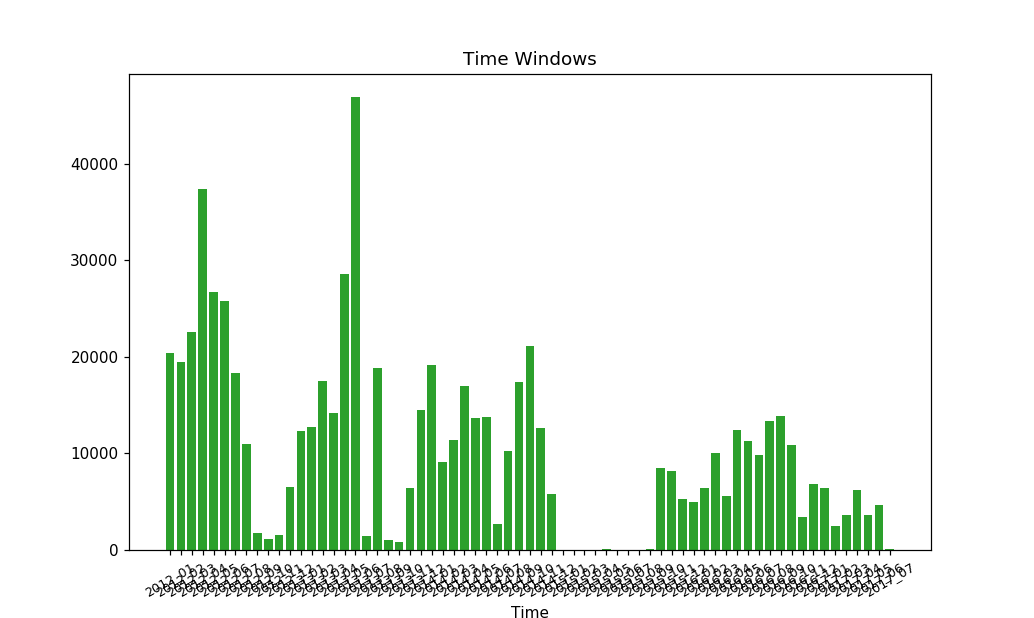

CPU times: user 17min 22s, sys: 2.22 s, total: 17min 24s
Wall time: 17min 54s


In [18]:
%%time

from operator import itemgetter

def corpus_info():

    cursor = get_collection_cursor()
    
    corpus = {}
    doc_count = 0
        
    for doc in cursor:        
        doc_date = dateparser.parse(doc['PublicationDateTime']).strftime('%Y_%m')        
        if (doc_date in corpus):
            corpus[doc_date].append(doc['Id'])   
        else:
            corpus[doc_date] = [doc['Id']]
            
        doc_count += 1       
        if (doc_count % 50000) == 0:
            print("Counted {} documents so far ".format(doc_count) + datetime.now().strftime("%H:%M:%S"))

    with open('data/eos/data_windows.pkl', 'wb') as f:
        pickle.dump(corpus, f)
    
    x = sorted(corpus) # time window
    y = [] # number of docs
    for item in x:
        y.append(len(corpus[item]))
        
    print(x)
    print(y)
    print('total number of documents: %d' % sum(y))

    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, size='small')
    plt.title('Time Windows')
    plt.xlabel('Time')
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('data/eos/graphs/windows_corpus_info_2016_2017.png', bbox_inches='tight', dpi=800)

corpus_info()

In [19]:
def get_collection_cursor(ids):
    db = get_db()
    return db.get_collection('eos_violence').find({"Id": {'$in': ids }}).batch_size(1000)

In [20]:
def graph_corpus(corpus):
    x = sorted(corpus) # time window
    y = [] # number of docs
    for item in x:
        y.append(len(corpus[item]))
        
    print(x)
    print(y)
    print('total number of documents: %d' % sum(y))

    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, size='small')
    plt.title('Time Windows')
    plt.xlabel('Time')
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('data/eos/graphs/windows_corpus_info_2016_2017.png', bbox_inches='tight', dpi=800)    

In [22]:
%%time


import random

with open('data/eos/data_windows.pkl', 'rb') as f:
    corpus = pickle.load(f)
    
x = sorted(corpus) # time window
y = [] # number of docs
for item in x:
    y.append(len(corpus[item]))
    
print(min(y))
average = int(sum(y) / float(len(y)))
print(average)    

# for window in corpus:
#     random.shuffle(corpus[window])
#     if (len(corpus[window]) > 75000 ):
#         limit = int(len(corpus[window]) / 2)
#         doc_ids = corpus[window][:limit]
#         corpus[window] = doc_ids

bin_location = 'dynamic_nmf/data/windowbin/slices/tokenized_window_%s.gz'

graph_corpus(corpus)

f_all = gzip.open(bin_location  % 'all', 'w') 

for window in corpus:
    print("Processing %s documents so far " % format(window) + datetime.now().strftime("%H:%M:%S"))
    cursor = get_collection_cursor(corpus[window])
    
    doc_list = []
    for doc in cursor:
        try:
            doc_list.append(doc['Id'] + '\t' + u' '.join(doc['tokens']))
        except:
            pass
    print(len(doc_list))
    
    f = gzip.open(bin_location  % window, 'w')         
    f.write( '\n'.join( doc_list ).encode("utf-8") )
    f_all.write( '\n'.join( doc_list ).encode("utf-8") )
    f.close()
    print("Finished %s documents so far " % format(window) + datetime.now().strftime("%H:%M:%S"))
    
f_all.close()

6
10156
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '2013_06', '2013_07', '2013_08', '2013_09', '2013_10', '2013_11', '2013_12', '2014_01', '2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015_03', '2015_04', '2015_05', '2015_06', '2015_07', '2015_08', '2015_09', '2015_10', '2015_11', '2015_12', '2016_01', '2016_02', '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', '2016_10', '2016_11', '2016_12', '2017_01', '2017_02', '2017_03', '2017_04', '2017_05', '2017_06', '2017_07']
[20416, 19505, 22537, 37400, 26776, 25819, 18341, 11017, 1732, 1180, 1536, 6506, 12291, 12740, 17523, 14196, 28566, 46969, 1490, 18852, 1043, 840, 6423, 14470, 19148, 9066, 11383, 16972, 13677, 13765, 2696, 10222, 17430, 21171, 12632, 5770, 6, 27, 46, 15

In [ ]:
length = [76147, 105437, 166768, 97922, 202805, 184538, 135195, 150944, 148744, 87716, 32146, 36870]

print(sum(length) / float(len(length)))